# **Delta Hedging with SPX Options**

In this approach, we will long an SPX option with a specific delta and one-month maturity. Implied volatility will be used to perform dynamic delta hedging throughout the option's life, with adjustments made continuously until the option expires.

*We will use the VIX to represent implied volatility and constant annualized risk-free rate.

In [103]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis

# Download VIX data
vix_data = yf.download('^VIX', start="2006-03-01", end="2024-12-20")
print(vix_data.head())

# Download SPX data
spx_ticker = "^GSPC"
spx_data = yf.download(spx_ticker, start="2006-03-01", end="2024-12-20", interval="1d")

[*********************100%***********************]  1 of 1 completed


Price                     Adj Close  Close   High    Low   Open Volume
Ticker                         ^VIX   ^VIX   ^VIX   ^VIX   ^VIX   ^VIX
Date                                                                  
2006-03-01 00:00:00+00:00     11.54  11.54  12.07  11.52  12.05      0
2006-03-02 00:00:00+00:00     11.72  11.72  11.95  11.56  11.79      0
2006-03-03 00:00:00+00:00     11.96  11.96  12.10  11.36  12.03      0
2006-03-06 00:00:00+00:00     12.74  12.74  12.91  12.22  12.22      0
2006-03-07 00:00:00+00:00     12.66  12.66  13.34  12.64  12.92      0


[*********************100%***********************]  1 of 1 completed


In [16]:
from google.colab import files
uploaded = files.upload()

file_names = list(uploaded.keys())

expiration_data = pd.read_csv(file_names[0])
expiration_data['Expiration'] = pd.to_datetime(expiration_data['Expiration'], format='%m/%d/%y')

Saving expiration.csv to expiration (1).csv


Now that we have our data, we need to reformat it so that we can use it efficiently. vix_data and spx_data have multilevel indexes. By taking the second level values and retaining only the "Close" column, we create new dataframes that only include the date and closing price of VIX and SPX. We  reset the index to make 'Date' a regular column and then merge the datasets by date.

In [104]:
# For VIX data
vix_data.columns = vix_data.columns.get_level_values(1)  # Flatten the multi-level columns
vix_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
vix_vol = vix_data[['Close']].copy()  # Extract Close column
vix_vol.index = pd.to_datetime(vix_vol.index).normalize().tz_localize(None)  # Normalize and remove timezone
vix_vol.reset_index(inplace=True)  # Reset the index and add it as a column
vix_vol.rename(columns={'index': 'Date'}, inplace=True)  # Rename 'index' column to 'Date'

# For SPX data
spx_data.columns = spx_data.columns.get_level_values(1)
spx_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
spx_data = spx_data[['Close']].copy()  # Extract Close column
spx_data.index = pd.to_datetime(spx_data.index).normalize().tz_localize(None)
spx_data.reset_index(inplace=True)
spx_data.rename(columns={'index': 'Date'}, inplace=True)

backtest_data = pd.merge(spx_data[['Date', 'Close']], vix_vol[['Date', 'Close']], on='Date', suffixes=('_spx', '_vix'))

Then merging our vix and spx data with contract expiration dates.

In [105]:
merged_data = pd.merge_asof(
    backtest_data,
    expiration_data,
    left_on='Date',
    right_on='Expiration',
    direction='forward'
)

In [106]:
print(merged_data.head())

        Date    Close_spx  Close_vix Expiration
0 2006-03-01  1280.660034      11.52 2006-03-24
1 2006-03-02  1283.209961      11.56 2006-03-24
2 2006-03-03  1284.199951      11.36 2006-03-24
3 2006-03-06  1275.670044      12.22 2006-03-24
4 2006-03-07  1271.109985      12.64 2006-03-24


We define the Black-Scholes formula as a function:

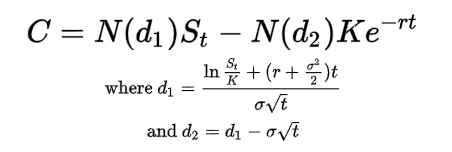

In [107]:
# Assume a fixed annualized risk-free rate of 4%
risk_free_rate = 0.04  # Annualized rate (4%)
spx_complete = merged_data
# Calculate Days to Maturity and T
spx_complete['Days_to_Maturity'] = (spx_complete['Expiration'] - spx_complete['Date']).dt.days
spx_complete['T'] = spx_complete['Days_to_Maturity'] / 365  # Use 365 days for consistency

def black_scholes(S, K, T, r, sigma):
    # Ensure no divide-by-zero or invalid calculations
    sigma = max(sigma, 1e-6)  # Avoid zero or near-zero volatility
    T = max(T, 1e-6)  # Avoid zero or near-zero time to maturity
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Calculate call option price and delta
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta

# Apply Black-Scholes to calculate option prices and deltas
spx_complete[['Option_Price', 'Delta']] = spx_complete.apply(
    lambda row: black_scholes(
        row['Close_spx'],  # S = SPX Close Price
        row['Close_spx'],  # K = ATM Strike Price
        row['T'],  # T = Time to Maturity in years
        risk_free_rate,  # r = Fixed Annualized Risk-Free Rate (4%)
        row['Close_vix'] / 100  # Convert VIX to decimal form
    ),
    axis=1,
    result_type="expand"
)

To simulate daily pricing and sensitivity (delta) tracking for an at-the-money SPX call option over time, this code calculates the theoretical price and delta of a one-month SPX call option each day using the Black-Scholes model. The strike price is reset at the beginning of each month to be at-the-money (equal to the SPX price), reflecting a strategy where a new option is opened monthly at the current SPX level.

In [108]:
# Parameters
Q = 100  # Quantity of options
transaction_cost_rate = 0.0005  # Transaction cost (0.05% per transaction)
risk_free_rate = 0.04  # Annualized risk-free rate (4%)

# Initial values
spx_complete.at[0, 'Hedging_Position'] = -spx_complete.at[0, 'Delta'] * Q
spx_complete.at[0, 'Transaction_Cost'] = abs(spx_complete.at[0, 'Hedging_Position']) * spx_complete.at[0, 'Close_spx'] * transaction_cost_rate
spx_complete.at[0, 'Cash_Position'] = -spx_complete.at[0, 'Hedging_Position'] * spx_complete.at[0, 'Close_spx'] - spx_complete.at[0, 'Transaction_Cost']
spx_complete.at[0, 'Interest_Accrued'] = 0.0  # No interest accrued on Day 0
spx_complete.at[0, 'Portfolio_Value'] = spx_complete.at[0, 'Cash_Position']

# Accrue interest from Day 1 onward
for i in range(1, len(spx_complete)):
    spx_complete.at[i, 'Interest_Accrued'] = spx_complete.at[i-1, 'Cash_Position'] * (risk_free_rate / 365)
    spx_complete.at[i, 'Portfolio_Value'] = spx_complete.at[i, 'Cash_Position'] + spx_complete.at[i, 'Interest_Accrued']
    current_row = spx_complete.iloc[i]
    previous_row = spx_complete.iloc[i - 1]

    # Recalculate option price and delta
    option_price, delta = black_scholes(
        current_row['Close_spx'],
        current_row['Close_spx'],  # ATM strike price
        current_row['T'],  # Time to maturity in years
        risk_free_rate,  # Risk-free rate
        current_row['Close_vix'] / 100  # Implied volatility in decimal
    )

    spx_complete.at[i, 'Option_Price'] = option_price
    spx_complete.at[i, 'Delta'] = delta

    # Adjust hedging position
    new_hedging_position = -delta * Q
    position_change = new_hedging_position - previous_row['Hedging_Position']
    transaction_cost = transaction_cost_rate * abs(position_change) * current_row['Close_spx']

    spx_complete.at[i, 'Hedging_Position'] = new_hedging_position
    spx_complete.at[i, 'Transaction_Cost'] = transaction_cost

    # Update cash position
    cash_change = -position_change * current_row['Close_spx'] - transaction_cost
    new_cash_position = previous_row['Cash_Position'] + cash_change
    spx_complete.at[i, 'Cash_Position'] = new_cash_position

    # Accrue interest on cash
    interest_accrued = new_cash_position * (risk_free_rate / 365)
    spx_complete.at[i, 'Interest_Accrued'] = interest_accrued

    # Update portfolio value
    portfolio_value = option_price * Q + new_cash_position + interest_accrued
    spx_complete.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate daily PnL
spx_complete['Daily_PnL'] = spx_complete['Portfolio_Value'].diff()

In [109]:
print(spx_complete.head())

        Date    Close_spx  Close_vix Expiration  Days_to_Maturity         T  \
0 2006-03-01  1280.660034      11.52 2006-03-24                23  0.063014   
1 2006-03-02  1283.209961      11.56 2006-03-24                22  0.060274   
2 2006-03-03  1284.199951      11.36 2006-03-24                21  0.057534   
3 2006-03-06  1275.670044      12.22 2006-03-24                18  0.049315   
4 2006-03-07  1271.109985      12.64 2006-03-24                17  0.046575   

   Option_Price     Delta  Hedging_Position  Transaction_Cost  Cash_Position  \
0     16.423387  0.540471        -54.047109         34.607986   69181.364734   
1     16.108191  0.539487        -53.948686          0.063149   69055.004287   
2     15.469195  0.539067        -53.906681          0.026971   69001.034405   
3     15.089857  0.534370        -53.436979          0.299593   68401.549480   
4     15.034920  0.532651        -53.265069          0.109258   68182.923407   

   Interest_Accrued  Portfolio_Value    Dail

Then calculating our monthly PnL:

In [85]:
spx_complete['Month'] = spx_complete['Date'].dt.to_period('M')

# Calculate Monthly P&L
monthly_pnl = spx_complete.groupby('Month')['Daily_PnL'].sum().reset_index()
monthly_pnl.rename(columns={'Daily_PnL': 'Monthly_PnL'}, inplace=True)

In [86]:
spx_complete['Cumulative_PnL'] = spx_complete['Daily_PnL'].cumsum()
monthly_pnl['Cumulative_PnL'] = monthly_pnl['Monthly_PnL'].cumsum()


In [87]:
print(monthly_pnl)

       Month  Monthly_PnL  Cumulative_PnL
0    2006-03  1424.435503     1424.435503
1    2006-04  1065.918831     2490.354335
2    2006-05 -1272.110894     1218.243440
3    2006-06   -93.027579     1125.215861
4    2006-07   378.214780     1503.430641
..       ...          ...             ...
221  2024-08  -527.468621    10985.332012
222  2024-09  3017.004322    14002.336334
223  2024-10  -885.812108    13116.524227
224  2024-11  -317.221219    12799.303008
225  2024-12 -3509.176393     9290.126615

[226 rows x 3 columns]


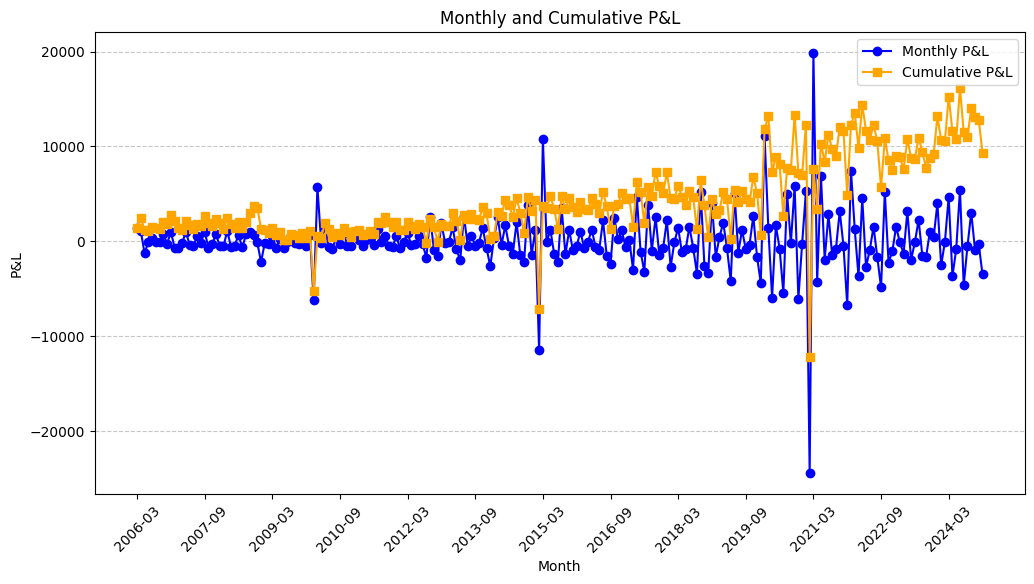

In [93]:
# Simplify x-axis
plt.figure(figsize=(12, 6))

# Convert 'Month' column to string
monthly_pnl['Month_Str'] = monthly_pnl['Month'].astype(str)

# Line plot for Monthly P&L
plt.plot(monthly_pnl['Month_Str'], monthly_pnl['Monthly_PnL'], marker='o', label='Monthly P&L', color='blue')

# Line plot for Cumulative P&L
plt.plot(monthly_pnl['Month_Str'], monthly_pnl['Cumulative_PnL'], marker='s', label='Cumulative P&L', color='orange')

# Formatting
plt.title('Monthly and Cumulative P&L')
plt.xlabel('Month')
plt.ylabel('P&L')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Simplify x-axis ticks
step = len(monthly_pnl['Month_Str']) // 12  # Show only 12 ticks
plt.xticks(ticks=monthly_pnl['Month_Str'][::step], rotation=45)

# Show plot
plt.show()


## Key Observations

We can see significant fluctuations in monthly P&L. The hedging strategy appears highly sensitive to volatility, with extreme negative and positive outcomes during certain periods. The large negative spike around 2008 corresponds to the financial crisis, while another major drop aligns with the COVID-19 market volatility in 2020.

Despite periodic losses, the overall cumulative P&L shows an upward trajectory, indicating that the strategy has been profitable over the long term. Periods of recovery following losses show the effectiveness of the strategy during stable market conditions.The hedging approach is highly reactive to market volatility. Large spikes in monthly P&L suggest the strategy benefits from increased market movement but suffers during sharp downturns.

The chart demonstrates the dual nature of delta hedging: while it can mitigate some risks, it is not immune to extreme market events. The cumulative gains suggest the strategy's long-term robustness, but it requires careful management during high-volatility periods.



In [100]:
# Parameters
Q = 100  # Quantity of options
transaction_cost_rate = 0.0005  # Transaction cost (0.05% per transaction)
risk_free_rate = 0.04  # Annualized risk-free rate (4%)
fixed_deltas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Fixed deltas to evaluate

# Prepare a dataframe to store results
hedging_error_results = []

for fixed_delta in fixed_deltas:
    # Createcopy of the dataframe for the fixed delta
    spx_fixed = spx_complete.copy()

    # Initialize Day 0 values
    spx_fixed.at[0, 'Hedging_Position'] = -fixed_delta * Q
    spx_fixed.at[0, 'Transaction_Cost'] = abs(spx_fixed.at[0, 'Hedging_Position']) * spx_fixed.at[0, 'Close_spx'] * transaction_cost_rate
    spx_fixed.at[0, 'Cash_Position'] = -spx_fixed.at[0, 'Hedging_Position'] * spx_fixed.at[0, 'Close_spx'] - spx_fixed.at[0, 'Transaction_Cost']
    spx_fixed.at[0, 'Interest_Accrued'] = 0.0
    spx_fixed.at[0, 'Portfolio_Value'] = spx_fixed.at[0, 'Cash_Position']

    # Simulate portfolio for subsequent days
    for i in range(1, len(spx_fixed)):
        current_row = spx_fixed.iloc[i]
        previous_row = spx_fixed.iloc[i - 1]

        # Adjust hedging position
        new_hedging_position = -fixed_delta * Q
        position_change = new_hedging_position - previous_row['Hedging_Position']
        transaction_cost = transaction_cost_rate * abs(position_change) * current_row['Close_spx']

        spx_fixed.at[i, 'Hedging_Position'] = new_hedging_position
        spx_fixed.at[i, 'Transaction_Cost'] = transaction_cost

        # Update cash position
        cash_change = -position_change * current_row['Close_spx'] - transaction_cost
        new_cash_position = previous_row['Cash_Position'] + cash_change
        spx_fixed.at[i, 'Cash_Position'] = new_cash_position

        # Accrue interest on cash
        interest_accrued = new_cash_position * (risk_free_rate / 365)
        spx_fixed.at[i, 'Interest_Accrued'] = interest_accrued

        # Update portfolio value
        portfolio_value = new_cash_position + interest_accrued
        spx_fixed.at[i, 'Portfolio_Value'] = portfolio_value

    # Calculate daily PnL and hedging errors
    spx_fixed['Daily_PnL'] = spx_fixed['Portfolio_Value'].diff()
    spx_fixed['Hedging_Error'] = spx_fixed['Daily_PnL'] - spx_fixed['Hedging_Position'].shift(1) * spx_fixed['Close_spx'].diff()

    # Add results to the summary list
    spx_fixed['Fixed_Delta'] = fixed_delta
    hedging_error_results.append(spx_fixed[['Date', 'Fixed_Delta', 'Hedging_Error']])

# Combine results
hedging_error_summary = pd.concat(hedging_error_results, ignore_index=True)

# Group by fixed delta and calculate summary statistics
hedging_error_stats = hedging_error_summary.groupby('Fixed_Delta')['Hedging_Error'].agg(
    Mean='mean',
    StdDev='std',
    Median='median',
    Min='min',
    Max='max'
).reset_index()


In [102]:
print(hedging_error_stats)

   Fixed_Delta       Mean       StdDev      Median           Min           Max
0          0.5   50.60915  1297.788692   91.503906 -11417.993164   8609.008789
1          0.6   60.73098  1557.346430  109.804688 -13701.591797  10330.810547
2          0.7   70.85281  1816.904168  128.105469 -15985.190430  12052.612305
3          0.8   80.97464  2076.461906  146.406250 -18268.789062  13774.414062
4          0.9   91.09647  2336.019645  164.707031 -20552.387695  15496.215820
5          1.0  101.21830  2595.577383  183.007812 -22835.986328  17218.017578
